In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
# read in all the words
words = open('/content/name.txt', 'r').read().splitlines()
words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and Mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X,Y = [],[]
  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, X.dtype, Y.shape, Y.dtype)
  return X,Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [93]:
# MLP revisited

n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),           generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5)  # * 0.2
b1 = torch.randn(n_hidden,                       generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01
b2 = torch.randn(vocab_size,                     generator=g) * 0
parameters = [C, W1, b1, W2, b2]
print(f'number of parameters: {sum(p.nelement() for p in parameters)}') # total number of parameters
for p in parameters:
  p.requires_grad = True

number of parameters: 11897


In [89]:
(torch.randn(100000)*0.2).std()

tensor(0.1996)

In [90]:
n_embed*block_size

30

In [92]:
(5/3) / (30**0.5)

0.3042903097250923

tensor(-0.0043) tensor(0.9965)
tensor(-0.0019) tensor(1.0050)


(array([2.08661302e-05, 1.04330651e-04, 2.08661302e-04, 2.29527432e-04,
        3.54724213e-04, 6.25983906e-04, 1.50236137e-03, 1.85708559e-03,
        3.86023408e-03, 5.52952450e-03, 1.06625925e-02, 1.60460541e-02,
        2.63330563e-02, 3.89987973e-02, 6.11377614e-02, 9.30003422e-02,
        1.31853077e-01, 1.85166039e-01, 2.46032541e-01, 3.13451008e-01,
        3.76299792e-01, 4.13984023e-01, 4.26795827e-01, 4.12231268e-01,
        3.61651768e-01, 2.96319915e-01, 2.26376646e-01, 1.71039669e-01,
        1.20543634e-01, 8.18578287e-02, 5.54413079e-02, 3.66409246e-02,
        2.19303028e-02, 1.42515669e-02, 8.32558594e-03, 5.59212289e-03,
        2.64999853e-03, 1.89881785e-03, 1.08503877e-03, 6.05117775e-04,
        3.12991953e-04, 2.08661302e-04, 1.04330651e-04, 2.08661302e-05,
        2.08661302e-05, 2.08661302e-05, 2.08661302e-05, 0.00000000e+00,
        0.00000000e+00, 2.08661302e-05]),
 array([-5.36115742, -5.12153464, -4.88191187, -4.64228909, -4.40266632,
        -4.16304355, 

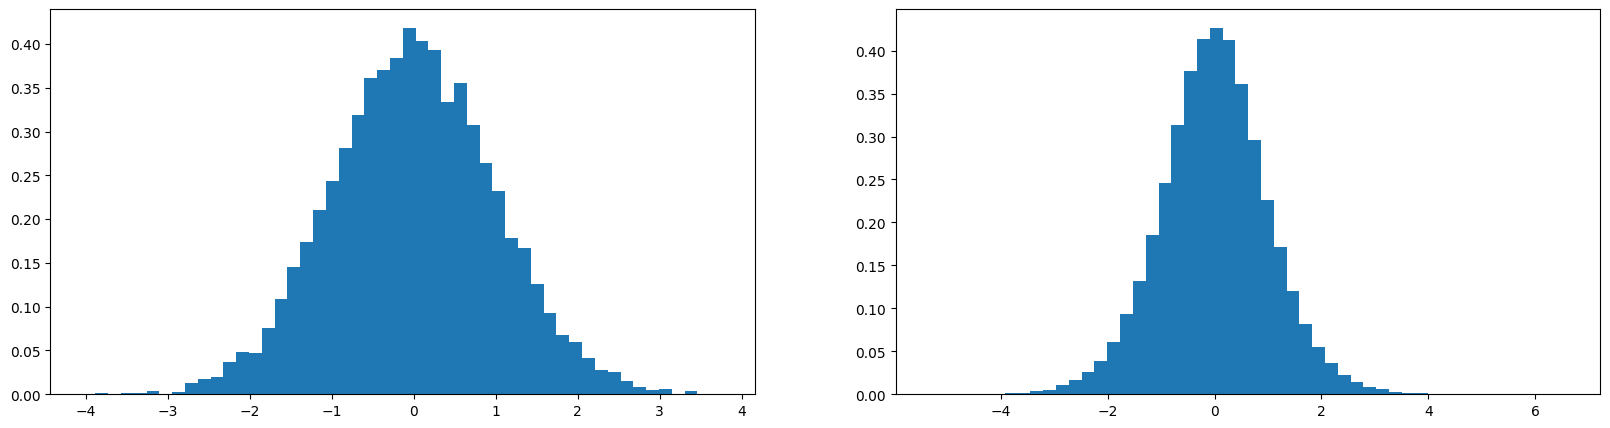

In [85]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x@w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True)

In [94]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb,YB = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] #embed the characters inot vecotrs
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, YB) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: #print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


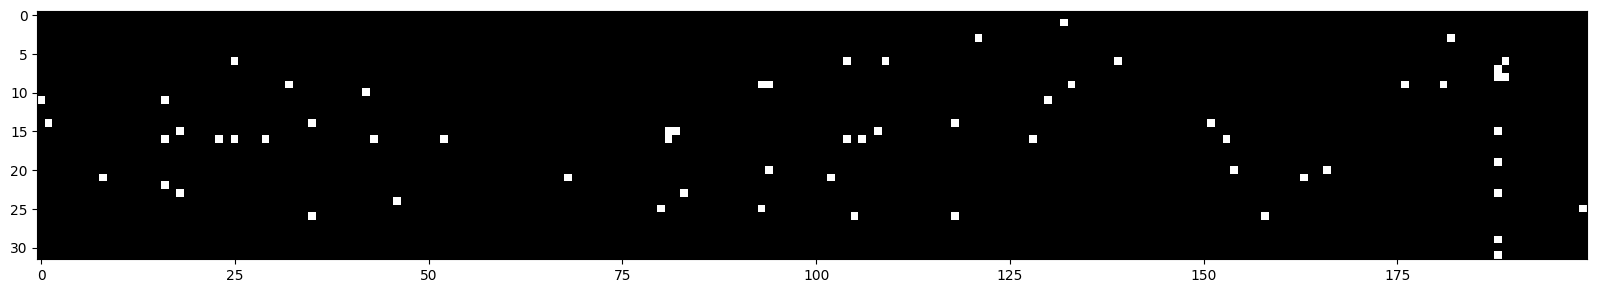

In [64]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([3.74609386, 0.85156253, 0.56640627, 0.46875001, 0.40234376,
        0.39843751, 0.28125001, 0.33203126, 0.29296876, 0.27343751,
        0.26953126, 0.28906251, 0.26953126, 0.26562501, 0.29687501,
        0.25390626, 0.19140626, 0.30078126, 0.19140626, 0.41015626,
        0.35156251, 0.35546876, 0.41796876, 0.33984376, 0.35937501,
        0.48437501, 0.51953127, 0.39453126, 0.39453126, 0.46875001,
        0.27734376, 0.33593751, 0.23437501, 0.28515626, 0.17187501,
        0.28515626, 0.21484376, 0.23046876, 0.14453125, 0.24609376,
        0.25000001, 0.23046876, 0.31640626, 0.29687501, 0.30468751,
        0.51953127, 0.50781252, 0.55859377, 1.01953128, 4.13281262]),
 array([-1.00000000e+00, -9.60000001e-01, -9.20000002e-01, -8.80000004e-01,
        -8.40000005e-01, -8.00000006e-01, -7.60000007e-01, -7.20000008e-01,
        -6.80000010e-01, -6.40000011e-01, -6.00000012e-01, -5.60000013e-01,
        -5.20000014e-01, -4.80000015e-01, -4.40000017e-01, -4.00000018e-01,
        -3.600

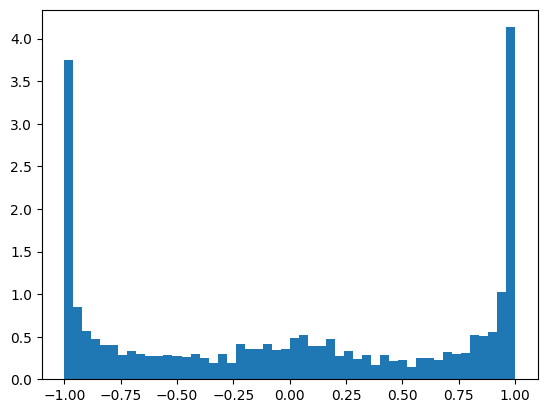

In [69]:
plt.hist(h.view(-1).tolist(), bins=50, density=True)

(array([0.00041793, 0.        , 0.        , 0.0012538 , 0.0012538 ,
        0.0012538 , 0.00167173, 0.0025076 , 0.00459726, 0.0037614 ,
        0.00752279, 0.00668693, 0.01295592, 0.01588145, 0.01713525,
        0.02507597, 0.03594223, 0.05015195, 0.0660334 , 0.06686926,
        0.0927811 , 0.0965425 , 0.11660328, 0.15338137, 0.19350293,
        0.29715029, 0.37781133, 0.16717316, 0.13666406, 0.13373853,
        0.11493155, 0.10448322, 0.08901971, 0.07857138, 0.04806228,
        0.03636016, 0.0292553 , 0.02298631, 0.01462765, 0.01253799,
        0.01337385, 0.00794072, 0.00668693, 0.00167173, 0.00167173,
        0.00167173, 0.0025076 , 0.00167173, 0.        , 0.00041793]),
 array([-9.74666119, -9.37279734, -8.99893349, -8.62506964, -8.25120579,
        -7.87734194, -7.50347809, -7.12961424, -6.75575039, -6.38188654,
        -6.00802269, -5.63415884, -5.26029499, -4.88643114, -4.51256729,
        -4.13870344, -3.76483959, -3.39097574, -3.01711189, -2.64324804,
        -2.26938419, -1.89

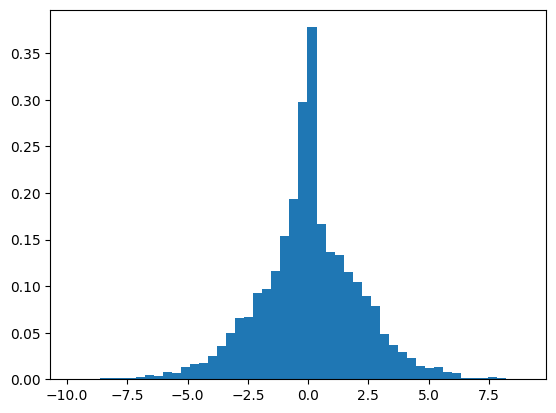

In [70]:
plt.hist(hpreact.view(-1).tolist(), bins=50, density=True)

In [71]:
logits[0]

tensor([-2.6747,  2.1231, -0.6957, -0.1796,  0.2563,  2.4494, -1.8890, -2.4445,
        -1.0199,  2.9168, -2.3774, -0.5807,  3.0092,  1.9834,  3.8758,  1.2065,
        -0.8337, -3.8639,  1.6995,  1.6315,  0.5563, -2.8112,  0.3735, -2.5029,
        -2.7556,  2.9825, -0.0861], grad_fn=<SelectBackward0>)

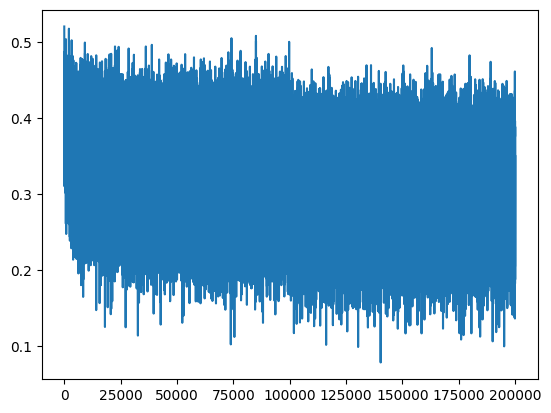

In [95]:
plt.plot(lossi)

In [96]:
@torch.no_grad() # this decorator disable gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N,n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [97]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    emb = C[torch.tensor([context])] # (1,block_size,n_embd)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.
joce.
quint.
salin.
alianni.
waveron.
jaryxin.
kaellissa.
med.
edi.
abette.
